<a href="https://colab.research.google.com/github/bobadams1/land_use_google_earth_engine/blob/main/land_use_categorization_of_GEE_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
from tqdm.notebook import tqdm

# Pytorch
import torch
import torchvision
import torchsummary
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
import random
SEED = 2187
np.random.seed(SEED)

Set up Model Carbon Emissions Tracking
Many thanks to Mel Hanna at Climate Change AI (https://www.climatechange.ai/)
https://colab.research.google.com/drive/1elYSajW0_qxA_6k-B8w4TGR5ec8vaw5f?usp=sharing#scrollTo=vUiCHIpvYSW2

In [4]:
!pip install codecarbon
!pip install dash
!pip install dash-bootstrap-components==0.13.1
!pip install netCDF4
!pip install fire
!pip install optuna

!mkdir code_carbon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.8/179.8 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.6 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 2.3.7
    Uninstalling Werkzeug-2.3.7:
      Successfully uninstalled Werkzeug-2.3.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.3/197.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=11693

In [5]:
from codecarbon import EmissionsTracker
from google.colab.output import eval_js

In [6]:
# carbon baseline
tracker = EmissionsTracker(
    output_dir = "./code_carbon/",
    output_file = "emissions.csv"
)

tracker.start()
print(tracker._geo)
print(tracker._hardware)
print(tracker._hardware[1].total_power())
emissions = tracker.stop()
print(f"Emissions from this run: {emissions:5f} kg CO2eq")

[codecarbon INFO @ 21:11:55] [setup] RAM Tracking...
[codecarbon INFO @ 21:11:55] [setup] GPU Tracking...
[codecarbon INFO @ 21:11:55] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 21:11:55] [setup] CPU Tracking...
[codecarbon WARNING @ 21:11:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:11:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:11:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 21:11:57] >>> Tracker's metadata:
[codecarbon INFO @ 21:11:57]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:11:57]   Python version: 3.10.12
[codecarbon INFO @ 21:11:57]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 21:11:57]   Available RAM : 12.678 GB
[codecarbon INFO @ 21:11:57]   CPU count: 2
[codecarbon INFO @ 21:11:57]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 21:11:57]   GPU

GeoMetadata(country_iso_code=NLD, country_name=Netherlands, region=groningen)
[RAM(), GPU() (Tesla T4), CPU(Intel(R) Xeon(R) CPU @ 2.00GHz > 85W [generic])]
Power(kW=0)
Emissions from this run: 0.000000 kg CO2eq


Sourcing Training Data from https://github.com/phelber/EuroSAT

This dataset contains 27000 georeferenced images categorized by land usage across 10 classes

In [9]:
!wget https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip?download=1 -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2023-08-17 21:18:31--  https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip?download=1
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94658721 (90M) [application/octet-stream]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  90.27M  95.2MB/s    in 0.9s    

2023-08-17 21:18:32 (95.2 MB/s) - ‘EuroSAT.zip’ saved [94658721/94658721]

replace EuroSAT/EuroSAT_RGB/Forest/Forest_864.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


Traning Data EDA

AnnualCrop


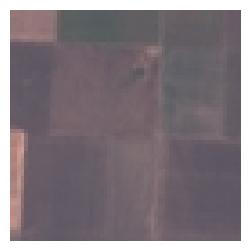

In [10]:
# !ls EuroSAT/EuroSAT_RGB/AnnualCrop/
i=0
j=1

base_path = 'EuroSAT/EuroSAT_RGB/'
category_list = ['AnnualCrop', 'HerbaceousVegetation', 'Industrial', 'PermanentCrop', 'River',
'Forest', 'Highway', 'Pasture', 'Residential', 'SeaLake']
image_path = f'{category_list[i]}_{j}.jpg'

img = Image.open(base_path + '/' + category_list[i] + "/" + image_path)
print(category_list[i])
plt.figure(figsize = (3,3))
plt.axis('off')
plt.imshow(img);

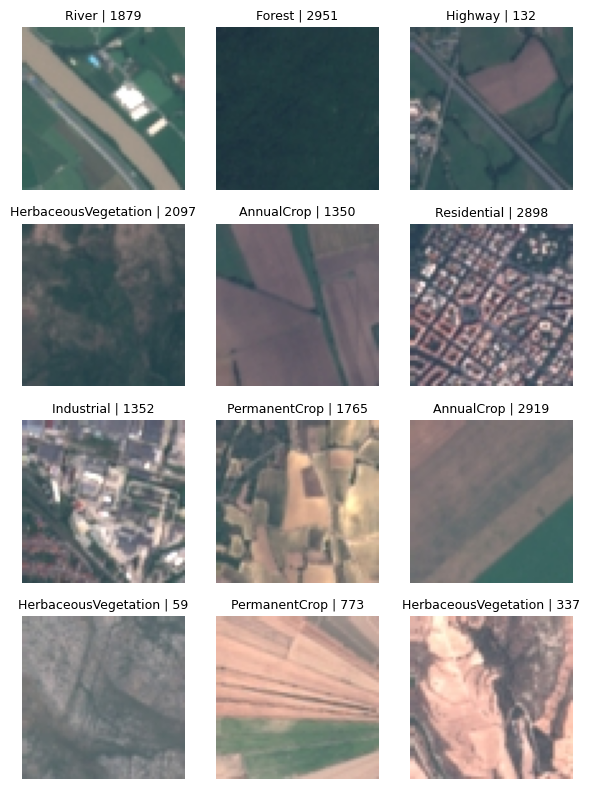

In [11]:
# Random Images from all classes
image_count = 12
cols = 3
rows = image_count // cols

fig, ax = plt.subplots(rows, cols, figsize = ((cols*2),((rows) *2)))

for n in range(image_count):
  i = np.random.choice(range(0,10))
  j_range = len(os.listdir(base_path + '/' + category_list[i] + '/'))
  j = np.random.choice(range(1, j_range +1))
  # print(category_list[i], " | Image:",j)

  img = Image.open(base_path + '/' + category_list[i] + "/" + category_list[i] + "_" + str(j) + ".jpg")
  ax[n % rows, n//rows].axis('off')
  ax[n % rows, n//rows].set_title(f"{category_list[i]} | {j}", fontsize = 9)
  ax[n % rows, n//rows].imshow(img)
plt.tight_layout()

Load the Dataset

In [12]:
class EuroSat(data.Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform

  def __getitem__(self, index):
    if self.transform:
      x = self.transform(dataset[index][0])
    else:
      x = dataset[index][0]

    y = dataset[index][1]
    return x, y

  def __len__(self):
    return len(dataset)

ImageNet Normalization

https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670/2

In [13]:
image_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

In [14]:
data_dir = 'EuroSAT/EuroSAT_RGB/'
dataset = datasets.ImageFolder(data_dir)

class_names = dataset.classes

print(f"{len(class_names)} total classes available in the dataset, comprising:\n",', '.join(class_names))
print()


10 total classes available in the dataset, comprising:
 AnnualCrop, Forest, HerbaceousVegetation, Highway, Industrial, Pasture, PermanentCrop, Residential, River, SeaLake



Apply Transformations, Normalizations and Train-Test Split

In [15]:
train_data = EuroSat(dataset, train_transform)
test_data = EuroSat(dataset, test_transform)

train_size = 0.8
indices = list(range(int(len(dataset))))
split = int(train_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices = indices[:split])
test_data = data.Subset(test_data, indices = indices[split:])

print(f"{len(train_data)} training images")
print(f"{len(test_data)} testing images")

21600 training images
5400 testing images


Dataloader for Pytorch

In [16]:
num_workers = 2
batch_size = 16

train_dataloader = data.DataLoader(train_data,
                                   batch_size = batch_size,
                                   shuffle = True,
                                   num_workers = num_workers
                                   )
test_dataloader = data.DataLoader(test_data,
                                  batch_size = batch_size,
                                  shuffle = False,
                                  num_workers = num_workers)

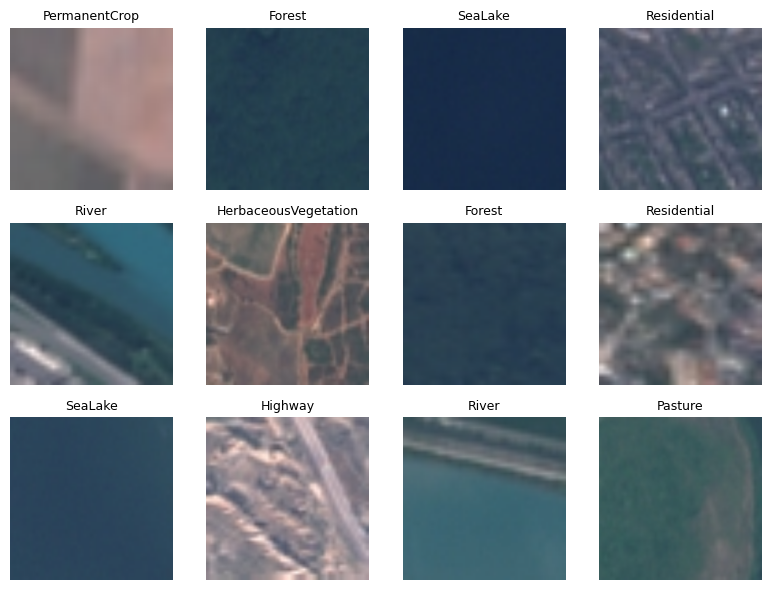

In [17]:
# Random Images from all classes
image_count = 12
cols = 4
rows = image_count // cols
inputs, classes = next(iter(train_dataloader))

fig, ax = plt.subplots(rows, cols, figsize = ((cols*2),((rows) *2)))

for n in range(image_count):
  image = inputs[n].numpy().transpose((1,2,0)) #bgr-rgb
  image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

  title = class_names[classes[n]]
  ax[n % rows, n//rows].axis('off')
  ax[n % rows, n//rows].set_title(title, fontsize = 9)
  ax[n % rows, n//rows].imshow(image)
plt.tight_layout()

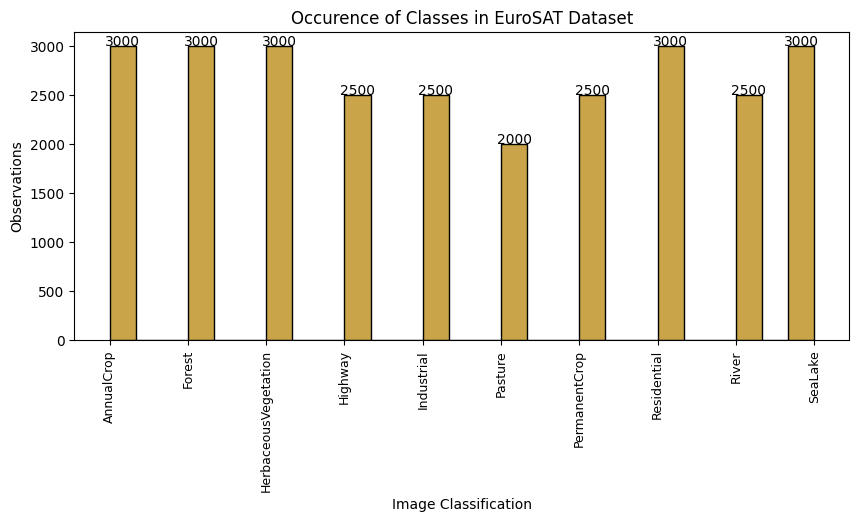

In [18]:
plt.figure(figsize=(10, 4))
hist = sns.histplot(dataset.targets, color = 'darkgoldenrod')
hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation = 90, fontsize = 9)
hist.set_title('Occurence of Classes in EuroSAT Dataset')
hist.set_ylabel('Observations')
hist.set_xlabel('Image Classification')

for p in hist.patches:
  height = p.get_height() #get bar height
  if height ==0: #skip zero-height bars or open patches
    continue
  else:
    hist.text(x = p.get_x()+(p.get_width()/2), # center on bar horizontally
    y = height+10, # padded above bar
    s = '{:.0f}'.format(height), # ignore decimals
    ha = 'center') # algin center
    # Kalli Chen - https://medium.com/swlh/quick-guide-to-labelling-data-for-common-seaborn-plots-736e10bf14a9
plt.show()

Model Instantiation
ResNet-50

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(format(device))

if str(device) == 'cuda:0':
  print(format(torch.cuda.get_device_name(0)))

cuda:0
Tesla T4


In [20]:
model = models.resnet50(pretrained = True)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)

torchsummary.summary(model, (3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 93.0MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

Model Parameters

In [21]:
n_epochs = 5
lr = 1e-3

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

In [22]:
def train(model, dataloader, criterion, optimizer):
  model.train()
  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients.  Clear off previous weights to obtain new ones.
    optimizer.zero_grad()

    #forward pass
    outputs = model(inputs)

    #compute loss
    loss = criterion(outputs, labels)

    #compute the gradients from loss
    loss.backward()

    #update weights based on gadients
    optimizer.step()

    # Calculate statistics
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print("Train Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

In [23]:
def evaluate(model, dataloader, criterion):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  #calculate epoch loss and accurach
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = ((running_total_correct) / len(dataloader.dataset)) * 100
  print("Test Loss: {:.2f}; Accuracy: {:.2f}".format(epoch_loss, epoch_accuracy))

  return epoch_loss, epoch_accuracy

Model Training

In [24]:
# Track best loss, best model weight with lowest loss
best_loss = np.inf
best_model = None

# carbon baseline
tracker = EmissionsTracker(
    output_dir = "./code_carbon/",
    output_file = "EuroSat_Training_emissions.csv"
)

tracker.start()
print(tracker._geo)
print(tracker._hardware)
print(tracker._hardware[1].total_power())

# Model Training
for epoch in range(n_epochs):
  print("Epoch {}".format(epoch+1))
  train(model, train_dataloader, criterion, optimizer)
  test_loss, _ = evaluate(model, test_dataloader, criterion)

  if test_loss < best_loss:
    best_loss = test_loss
    best_model = model.state_dict()


emissions = tracker.stop()
print(f"Emissions from this run: {emissions:5f} kg CO2eq")

[codecarbon INFO @ 21:20:11] [setup] RAM Tracking...
[codecarbon INFO @ 21:20:11] [setup] GPU Tracking...
[codecarbon INFO @ 21:20:11] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 21:20:11] [setup] CPU Tracking...
[codecarbon WARNING @ 21:20:11] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 21:20:13] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon INFO @ 21:20:13] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 21:20:13] >>> Tracker's metadata:
[codecarbon INFO @ 21:20:13]   Platform system: Linux-5.15.109+-x86_64-with-glibc2.35
[codecarbon INFO @ 21:20:13]   Python version: 3.10.12
[codecarbon INFO @ 21:20:13]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 21:20:13]   Available RAM : 12.678 GB
[codecarbon INFO @ 21:20:13]   CPU count: 2
[codecarbon INFO @ 21:20:13]   CPU model: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon INFO @ 21:20:13]   GPU

GeoMetadata(country_iso_code=NLD, country_name=Netherlands, region=groningen)
[RAM(), GPU() (Tesla T4), CPU(Intel(R) Xeon(R) CPU @ 2.00GHz > 85W [generic])]
Power(kW=0)
Epoch 1


  0%|          | 0/1350 [00:00<?, ?it/s]

[codecarbon INFO @ 21:20:28] Energy consumed for RAM : 0.000020 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:20:28] Energy consumed for all GPUs : 0.000268 kWh. Total GPU Power : 64.14274442898004 W
[codecarbon INFO @ 21:20:28] Energy consumed for all CPUs : 0.000178 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:20:28] 0.000465 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:20:43] Energy consumed for RAM : 0.000040 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:20:43] Energy consumed for all GPUs : 0.000550 kWh. Total GPU Power : 67.92032705509122 W
[codecarbon INFO @ 21:20:43] Energy consumed for all CPUs : 0.000355 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:20:43] 0.000944 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:20:58] Energy consumed for RAM : 0.000059 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:20:58] Energy consumed for all GPUs : 0.000831 kWh. Total GPU Power : 67.4524234888499 

Train Loss: 1.01; Accuracy: 70.38


  0%|          | 0/338 [00:00<?, ?it/s]

[codecarbon INFO @ 21:23:58] Energy consumed for RAM : 0.000297 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:23:58] Energy consumed for all GPUs : 0.004250 kWh. Total GPU Power : 66.46688262576411 W
[codecarbon INFO @ 21:23:58] Energy consumed for all CPUs : 0.002660 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:23:58] 0.007207 kWh of electricity used since the beginning.


Test Loss: 0.33; Accuracy: 91.65
Epoch 2


  0%|          | 0/1350 [00:00<?, ?it/s]

[codecarbon INFO @ 21:24:13] Energy consumed for RAM : 0.000317 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:24:14] Energy consumed for all GPUs : 0.004530 kWh. Total GPU Power : 67.10506853688011 W
[codecarbon INFO @ 21:24:14] Energy consumed for all CPUs : 0.002837 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:24:14] 0.007684 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:24:28] Energy consumed for RAM : 0.000337 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:24:29] Energy consumed for all GPUs : 0.004819 kWh. Total GPU Power : 69.0015637242379 W
[codecarbon INFO @ 21:24:29] Energy consumed for all CPUs : 0.003015 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:24:29] 0.008171 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:24:43] Energy consumed for RAM : 0.000356 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:24:44] Energy consumed for all GPUs : 0.005103 kWh. Total GPU Power : 68.77538402392565 

Train Loss: 0.46; Accuracy: 85.54


  0%|          | 0/338 [00:00<?, ?it/s]

[codecarbon INFO @ 21:27:59] Energy consumed for RAM : 0.000614 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:27:59] Energy consumed for all GPUs : 0.008828 kWh. Total GPU Power : 67.9804168474809 W
[codecarbon INFO @ 21:27:59] Energy consumed for all CPUs : 0.005498 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:27:59] 0.014940 kWh of electricity used since the beginning.


Test Loss: 0.17; Accuracy: 95.15
Epoch 3


  0%|          | 0/1350 [00:00<?, ?it/s]

[codecarbon INFO @ 21:28:14] Energy consumed for RAM : 0.000634 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:28:14] Energy consumed for all GPUs : 0.009104 kWh. Total GPU Power : 66.18903464751223 W
[codecarbon INFO @ 21:28:14] Energy consumed for all CPUs : 0.005675 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:28:14] 0.015413 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:28:29] Energy consumed for RAM : 0.000654 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:28:29] Energy consumed for all GPUs : 0.009390 kWh. Total GPU Power : 68.73266573479579 W
[codecarbon INFO @ 21:28:29] Energy consumed for all CPUs : 0.005852 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:28:29] 0.015896 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:28:44] Energy consumed for RAM : 0.000673 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:28:44] Energy consumed for all GPUs : 0.009676 kWh. Total GPU Power : 68.75738713631861

Train Loss: 0.37; Accuracy: 88.36


  0%|          | 0/338 [00:00<?, ?it/s]

[codecarbon INFO @ 21:31:59] Energy consumed for RAM : 0.000931 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:31:59] Energy consumed for all GPUs : 0.013398 kWh. Total GPU Power : 67.99231456575599 W
[codecarbon INFO @ 21:31:59] Energy consumed for all CPUs : 0.008333 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:31:59] 0.022662 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:32:14] Energy consumed for RAM : 0.000950 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:32:14] Energy consumed for all GPUs : 0.013672 kWh. Total GPU Power : 65.92589874963114 W
[codecarbon INFO @ 21:32:14] Energy consumed for all CPUs : 0.008511 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:32:14] 0.023133 kWh of electricity used since the beginning.


Test Loss: 0.13; Accuracy: 95.93
Epoch 4


  0%|          | 0/1350 [00:00<?, ?it/s]

[codecarbon INFO @ 21:32:29] Energy consumed for RAM : 0.000970 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:32:29] Energy consumed for all GPUs : 0.013953 kWh. Total GPU Power : 67.5933476390391 W
[codecarbon INFO @ 21:32:29] Energy consumed for all CPUs : 0.008688 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:32:29] 0.023611 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:32:44] Energy consumed for RAM : 0.000990 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:32:44] Energy consumed for all GPUs : 0.014238 kWh. Total GPU Power : 68.41250105122212 W
[codecarbon INFO @ 21:32:44] Energy consumed for all CPUs : 0.008865 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:32:44] 0.024093 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:32:59] Energy consumed for RAM : 0.001010 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:32:59] Energy consumed for all GPUs : 0.014524 kWh. Total GPU Power : 68.69854563897327 

Train Loss: 0.31; Accuracy: 90.31


  0%|          | 0/338 [00:00<?, ?it/s]

[codecarbon INFO @ 21:36:15] Energy consumed for RAM : 0.001268 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:36:15] Energy consumed for all GPUs : 0.018245 kWh. Total GPU Power : 66.99450546242895 W
[codecarbon INFO @ 21:36:15] Energy consumed for all CPUs : 0.011349 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:36:15] 0.030861 kWh of electricity used since the beginning.


Test Loss: 0.11; Accuracy: 96.69
Epoch 5


  0%|          | 0/1350 [00:00<?, ?it/s]

[codecarbon INFO @ 21:36:30] Energy consumed for RAM : 0.001287 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:36:30] Energy consumed for all GPUs : 0.018520 kWh. Total GPU Power : 66.09586544739476 W
[codecarbon INFO @ 21:36:30] Energy consumed for all CPUs : 0.011525 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:36:30] 0.031333 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:36:45] Energy consumed for RAM : 0.001307 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:36:45] Energy consumed for all GPUs : 0.018807 kWh. Total GPU Power : 68.3955080191632 W
[codecarbon INFO @ 21:36:45] Energy consumed for all CPUs : 0.011703 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:36:45] 0.031817 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:37:00] Energy consumed for RAM : 0.001327 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:37:00] Energy consumed for all GPUs : 0.019094 kWh. Total GPU Power : 68.89409732836192 

Train Loss: 0.28; Accuracy: 90.86


  0%|          | 0/338 [00:00<?, ?it/s]

[codecarbon INFO @ 21:40:15] Energy consumed for RAM : 0.001585 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:40:16] Energy consumed for all GPUs : 0.022815 kWh. Total GPU Power : 66.98342218275081 W
[codecarbon INFO @ 21:40:16] Energy consumed for all CPUs : 0.014187 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:16] 0.038587 kWh of electricity used since the beginning.
[codecarbon INFO @ 21:40:27] Energy consumed for RAM : 0.001600 kWh. RAM Power : 4.754392147064209 W
[codecarbon INFO @ 21:40:27] Energy consumed for all GPUs : 0.023027 kWh. Total GPU Power : 66.33919953904642 W
[codecarbon INFO @ 21:40:27] Energy consumed for all CPUs : 0.014324 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 21:40:27] 0.038951 kWh of electricity used since the beginning.


Test Loss: 0.11; Accuracy: 96.41
Emissions from this run: 0.015140 kg CO2eq


In [210]:
model_dir = './drive/MyDrive/land_use_categorization_models/'
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = model_dir + 'best_model.pth'
torch.save(best_model, model_file)
print('Model successfully saved to{}'.format(model_file))

emissions = tracker.stop()
print(f"Emissions from this run: {emissions:5f} kg CO2eq")